# Fit a model of item similarity to inference task data

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tesser import tasks
from tesser import model
from tesser import figures

bids_dir = os.environ['TESSER_BIDS']
fig_dir = os.path.join(os.environ['TESSER_FIGURES'], 'model')

model_name = 'sr-g_a10'
model_dir = os.path.join(fig_dir, f'fit_{model_name}')
os.makedirs(model_dir, exist_ok=True)

## Load structure learning and inference task data

In [2]:
struct = tasks.load_struct(bids_dir)
induct = tasks.load_induct(bids_dir)
induct = tasks.score_induct(induct)

## Define inference model parameter search

In [3]:
# define free and fixed parameters
fixed = {'alpha': 0.1}
var_names = ['gamma', 'tau']
var_bounds = {
    'gamma': [0, 1],
    'tau': [0, 10],
}
question_param = None

# define similarity matrices
sim1_spec = {'alpha': 'alpha', 'gamma': 'gamma'}
sim2_spec = None

## Estimate best-fitting parameters

In [4]:
full_results = model.fit_induct(
    struct,
    induct,
    fixed,
    var_names,
    var_bounds,
    sim1_spec,
    sim2_spec=sim2_spec,
    question_param=question_param,
    n_job=6,
    n_rep=10,
)
full_results

,logl,n,k,alpha,gamma,tau
rep,,,,,,
0,-1356.573681,1554,2,0.1,1.000000,1.337324
1,-1356.573681,1554,2,0.1,1.000000,1.337325
2,-1356.573681,1554,2,0.1,1.000000,1.337325
3,-1356.573681,1554,2,0.1,1.000000,1.337324
4,-1356.573681,1554,2,0.1,1.000000,1.337326
5,-1356.582168,1554,2,0.1,0.994558,1.314330
6,-1356.573682,1554,2,0.1,1.000000,1.337378
7,-1356.573681,1554,2,0.1,1.000000,1.337322
8,-1356.573681,1554,2,0.1,1.000000,1.337296


In [5]:
results = model.save_fit_results(
    model_dir,
    full_results,
    fixed,
    var_names,
    var_bounds,
    sim1_spec,
    sim2_spec,
    question_param,
)
results

,logl,n,k,alpha,gamma,tau
rep,,,,,,
3,-1356.573681,1554,2,0.1,1.0,1.337324


## Get fitted response probabilities for inference

In [6]:
temp = results.copy()
stats = model.get_fitted_prob(
    temp,
    induct,
    struct,
    sim1_spec,
    sim2_spec=sim2_spec,
    question_param=question_param,
)
stats

,onset,duration,trial_type,environment,community,cue,opt1,opt2,within_opt,response,response_time,run,subject,correct,prob_response,prob_correct
0,0.000,8.000,central,ocean,1,2,16,20,2,NaN,NaN,1,100,NaN,NaN,NaN
1,8.500,2.974,boundary2,desert,2,4,10,19,1,2.0,2.974,1,100,0.0,0.467988,0.532012
2,11.974,3.191,central,desert,2,5,6,2,1,1.0,3.191,1,100,1.0,0.578883,0.578883
3,15.665,3.374,central,ocean,1,2,9,19,2,2.0,3.374,1,100,1.0,0.621355,0.621355
4,19.539,3.095,central,ocean,1,1,19,13,1,2.0,3.095,1,100,0.0,0.355322,0.644678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,100.861,2.026,central,desert,2,8,9,21,1,2.0,2.026,1,138,0.0,0.475404,0.524596
38,103.386,1.998,central,forest,3,14,19,15,2,2.0,1.998,1,138,1.0,0.572154,0.572154
39,105.884,1.114,central,ocean,1,21,14,2,2,2.0,1.114,1,138,1.0,0.618671,0.618671
40,107.498,0.623,boundary1,forest,3,11,10,16,2,1.0,0.623,1,138,0.0,0.424171,0.575829


## Mean probability by trial type

In [7]:
m = stats.groupby(['subject', 'trial_type'])[['correct', 'prob_correct']].mean().reset_index()
m['bias'] = (m['correct'] - .5) * 2
m['prob_bias'] = (m['prob_correct'] - .5) * 2
m['trial_type'] = m['trial_type'].map(
    {
        'central': 'Central',
        'boundary1': 'Boundary 1-Away',
        'boundary2': 'Boundary 2-Away',
    }
)

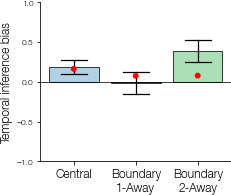

In [8]:
fig, ax = plt.subplots(figsize=(3.5, 3))
colors = figures.get_induct_colors()
# data
sns.barplot(
    data=m,
    x='trial_type',
    y='bias',
    hue='trial_type',
    palette=colors['light'],
    edgecolor='k',
    linewidth=0.75,
    dodge=False,
    capsize=0.425,
    zorder=0,
    ax=ax,
)
# model fit
sns.pointplot(
    data=m,
    x='trial_type',
    y='prob_bias',
    color='r',
    linewidth=0.75,
    dodge=False,
    join=False,
    ci=None,
    zorder=1000,
    ax=ax,
)
plt.setp(ax.lines, zorder=50, linewidth=1.25, color='k', label=None)
plt.setp(ax.collections, zorder=100, label=None)
ax.set(
    ylabel='Temporal inference bias',
    ylim=(-1, 1),
    yticks=np.arange(-1, 1.5, .5),
    xticklabels=['Central', 'Boundary\n1-Away', 'Boundary\n2-Away'],
);
ax.axline((0, 0), slope=0, color='k', linewidth=.75);
ax.spines['left'].set_bounds(-1, 1)
ax.set_xlabel('')
ax.get_legend().remove()
ax.tick_params(axis='x', labelsize='large');
fig.savefig(os.path.join(model_dir, f'induct_mean_fit.pdf'))

In [9]:
%load_ext watermark
%watermark -v -iv

Python implementation: CPython
Python version       : 3.7.6
IPython version      : 7.11.1

pingouin  : 0.3.12
mindstorm : 0.8.1
pandas    : 1.2.5
matplotlib: 3.4.2
seaborn   : 0.11.1
tesser    : 0.1.0
numpy     : 1.18.1

